In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Wheel:
    def __init__(self, outer_radius, inner_radius, mass, material, num_spokes):
        self.outer_radius = outer_radius  # meters
        self.inner_radius = inner_radius  # meters
        self.mass = mass  # kg
        self.material = material  # Material properties (dict)
        self.num_spokes = num_spokes  # Number of spokes

        # Calculate mass distribution
      #  self.ring_mass = 0.8 * mass  # Assume 80% of mass is in the outer ring
      #  self.spoke_mass = 0.2 * mass / num_spokes  # Remaining mass is in the spokes
        self.ring_mass = mass
            # Assume all mass is in the outer ring for simplicity



        self.mu = material['friction']  # Coefficient of rolling friction
        self.restitution = material['restitution']  # Elasticity of bounce
        
        # Structural stability (stress calculations)
        self.yield_strength = material['yield_strength']  # Maximum stress before deformation
        
    def get_normal_force(self):
        if self.position[1] <= self.radius:  # Contact with ground
            return self.mass * self.g
        return 0.0
    
    def get_friction_force(self, normal_force):
        return -self.mu * normal_force  # Opposing motion
    
    def get_air_resistance(self):
        drag_coefficient = 0.47  # Approx. for a cylinder
        air_density = 1.225  # kg/m³
      #  area = np.pi * self.radius ** 2
      # I think this should be the cross-sectional area of the wheel
        area = 2 * self.outer_radius * self.width  # Cross-sectional area of the wheel
        # Assuming the wheel is moving in the x-direction
        return -0.5 * drag_coefficient * air_density * area * self.velocity[0]**2 * np.sign(self.velocity[0])
    
    def get_rolling_friction(self, normal_force):
        # Rolling friction force = rolling resistance coefficient * normal force
        rolling_resistance_coefficient = self.material['rolling_resistance']
        return -rolling_resistance_coefficient * normal_force * np.sign(self.velocity[0])
    
    def update(self):
        normal_force = self.get_normal_force()
        friction_force = self.get_friction_force(normal_force)
        air_resistance = self.get_air_resistance()
        rolling_friction = self.get_rolling_friction(normal_force)
        
        net_force_x = friction_force + air_resistance + rolling_friction
        acceleration_x = net_force_x / self.mass
        self.velocity[0] += acceleration_x * self.dt
        self.position[0] += self.velocity[0] * self.dt
        
        if self.position[1] <= self.radius:  # Bouncing effect
            self.velocity[1] = -self.velocity[1] * self.restitution

    def moment_of_inertia(self):
        # Moment of inertia for the outer ring
      #  I_ring = self.ring_mass * self.outer_radius ** 2
        I_ring = self.ring_mass * (self.outer_radius ** 2 + self.inner_radius ** 2) / 2

        # Moment of inertia for the spokes (approximated as rods)
      #  I_spokes = self.num_spokes * (self.spoke_mass * (self.outer_radius ** 2 + self.inner_radius ** 2) / 2)
        I_spokes = 0
            # assuming spokes are negligible for simplicity

        # Total moment of inertia
        return I_ring + I_spokes

    def force_due_to_gravity(self, gravity=9.81):
        # Force due to gravity (weight)
        return self.mass * gravity

    def contact_patch_area(self):
        # Simplified contact patch area calculation
        return (self.outer_radius - self.inner_radius) * (self.inner_radius / 100)  # assuming 1/100th of the radius is in contact
        # we will likely be dealing with a incredibly small contact patch -- we adjusted to 1/100th of the radius
        # This is a simplification and should be adjusted based on actual tire characteristics

    def __str__(self):
        return (f"Wheel(inner_radius={self.inner_radius}, outer_radius={self.outer_radius}, mass={self.mass}, "
                f"material='{self.material}')")
    
    def apply_forces_to_bearing(self, bearing):
        normal_force = self.get_normal_force()
        friction_force = self.get_friction_force(normal_force)
        air_resistance = self.get_air_resistance()
        
        total_force = np.array([friction_force + air_resistance, -normal_force])
        bearing_force = np.linalg.norm(total_force)
        
        return bearing.friction_force(bearing_force)

carbon_fiber = {
    "friction": 0.02,
    "restitution": 0.8,
    "yield_strength": 600e6,   # Pa (example)
    "rolling_resistance": 0.015
}

# Example usage
if __name__ == "__main__":
    # f1_wheel = Wheel(radius=0.33, width=0.305, mass=10, material="Carbon Fiber")
    f1_wheel = Wheel(inner_radius=0.33, outer_radius=0.635, mass=10, material=carbon_fiber, num_spokes=10)
    print(f1_wheel)
    print(f"Moment of Inertia: {f1_wheel.moment_of_inertia()} kg*m^2")
    print(f"Force due to Gravity: {f1_wheel.force_due_to_gravity()} N")
    print(f"Contact Patch Area: {f1_wheel.contact_patch_area()} m^2")

class Bearing:
        def __init__(self, friction_coefficient):
            self.friction_coefficient = friction_coefficient

        def friction_force(self, normal_force):
            # Friction force = friction coefficient * normal force
            return self.friction_coefficient * normal_force

Wheel(inner_radius=0.33, outer_radius=0.635, mass=10, material='{'friction': 0.02, 'restitution': 0.8, 'yield_strength': 600000000.0, 'rolling_resistance': 0.015}')
Moment of Inertia: 2.5606250000000004 kg*m^2
Force due to Gravity: 98.10000000000001 N
Contact Patch Area: 0.0010065 m^2


In [3]:
class Wheel:
    def __init__(self, radius, mass, material, is_hollow=False):
        self.radius = radius  # meters
        self.mass = mass  # kg
        self.material = material  # Material properties (dict)
        self.is_hollow = is_hollow
        self.position = np.array([0.0, radius])  # (x, y) position
        self.velocity = np.array([2.0, 0.0])  # Initial velocity (m/s)
        self.angular_velocity = 0.0  # rad/s
        self.g = 9.81  # Gravity (m/s^2)
        self.dt = 0.01  # Time step (s)
        self.force = np.array([0.0, -self.mass * self.g])
        
        # Moment of inertia
        if is_hollow:
            self.inertia = 0.5 * mass * radius ** 2  # Hollow cylinder
        else:
            self.inertia = 0.5 * mass * radius ** 2  # Solid cylinder
        
        # Friction properties
        self.mu = material['friction']  # Coefficient of rolling friction
        self.restitution = material['restitution']  # Elasticity of bounce
        
        # Structural stability (stress calculations)
        self.yield_strength = material['yield_strength']  # Maximum stress before deformation
        
    def get_normal_force(self):
        if self.position[1] <= self.radius:  # Contact with ground
            return self.mass * self.g
        return max(0.0, self.mass * self.g - self.mass * self.acceleration[1])
    
                        # account for any upward force and therefore decrease to the normal force here
    
    def get_friction_force(self, normal_force):
        return -self.mu * normal_force  # Opposing motion
    
    def update(self):
        normal_force = self.get_normal_force()
        friction_force = self.get_friction_force(normal_force)
        self.force = friction_force
        
    def check_stability(self):
        stress = (self.mass * self.g) / (np.pi * self.radius ** 2)  # Approx. stress calculation
        return stress < self.yield_strength
    
    def simulate(self, time):
        times = np.arange(0, time, self.dt)
        Fforce_list = []
        time_list = []

        for t in times:
            self.update()
            Fforce_list.append(self.force)
            time_list.append(t)
    
        return np.array(Fforce_list), np.array(time_list)

# Define material properties
rubber = {'friction': 0.03, 'restitution': 0.8, 'yield_strength': 10e6}  # Example material properties

# Create and simulate the wheel
wheel = Wheel(radius=0.05, mass=0.2, material=rubber, is_hollow=False)
positions_time = wheel.simulate(2)

positions_time[0]
# positions_time[1]

array([-0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05886,
       -0.05886, -0.05886, -0.05886, -0.05886, -0.05886, -0.05

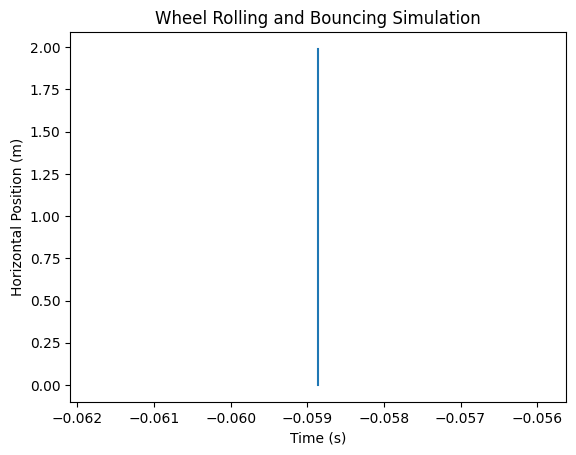

In [4]:
# Plot motion
plt.plot(positions_time[0], positions_time[1])
plt.xlabel("Time (s)")
plt.ylabel("Horizontal Position (m)")
plt.title("Wheel Rolling and Bouncing Simulation")
plt.show()

In [5]:
def get_air_resistance(self):
    drag_coefficient = 0.47  # Approx. for a cylinder
    air_density = 1.225  # kg/m³
    area = np.pi * self.radius ** 2
    return -0.5 * drag_coefficient * air_density * area * self.velocity[0]**2 * np.sign(self.velocity[0])

    air_resistance = self.get_air_resistance()
            
    net_force_x = friction_force + air_resistance
    acceleration_x = net_force_x / self.mass
    self.velocity[0] += acceleration_x * self.dt
    self.position[0] += self.velocity[0] * self.dt

    if self.position[1] <= self.radius:  # Bouncing effect
        self.velocity[1] = -self.velocity[1] * self.restitution
    else:
        self.velocity[1] -= self.g * self.dt
    self.position[1] += self.velocity[1] * self.dt

    # Rotational motion
    torque = friction_force * self.radius
    angular_acceleration = torque / self.inertia
    self.angular_velocity += angular_acceleration * self.dt